#**Installing EconML library**

In [13]:
!pip install econml

#**Import python libraries like Numpy, Pandas, Matplotlib, EconML and XGBoost**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor, XGBClassifier #XGBoost
from econml.dr import LinearDRLearner #EconML

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

#**Import the Customer Profile dataset**

In [15]:
# Import the sample multi-attribution data
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/ROI/multi_attribution_sample.csv"
multi_data = pd.read_csv(file_url)

In [16]:
# Data sample
multi_data.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


#**Defining Confounding Variables, Outcomes and Treatment Methods**

In [17]:
X = multi_data[["Size"]]  # confounding variable
Y = multi_data["Revenue"]  # amount of product purchased, or outcome
T_bin = multi_data[
    ["Tech Support", "Discount"]
]  # multiple interventions, or treatments

W = multi_data.drop(
    columns=["Tech Support", "Discount", "Revenue", "Size"]
)  # controls

In [18]:
# Average customer size per incentive combination
multi_data[["Size", "Tech Support", "Discount"]].groupby(
    by=["Tech Support", "Discount"], as_index=False
).mean().astype(int)

,Tech Support,Discount,Size
0,0,0,70943
1,0,1,96466
2,1,0,108978
3,1,1,171466


#**Defining the treament effect function**

In [19]:
# Define underlying treatment effect function
def TE_fn(X):
    return np.hstack([5000 + 2 / 100 * X, 5 / 100 * X])
true_TE = TE_fn(X)

#**Defining the true coefficients and intercepts for each treatment method**

In [20]:
true_coefs = [2 / 100, 5 / 100, 7 / 100]  # true coefficients
true_intercepts = [5000, 0, 5000]  # true intercepts
treatment_names = ["Tech Support", "Discount", "Tech Support & Discount"]  # three treatment methods

#**Encoding**

In [21]:
# Transform T to one-dimensional array with consecutive integer encoding
def treat_map(t):
    return np.dot(t, 2 ** np.arange(t.shape[0]))

T = np.apply_along_axis(treat_map, 1, T_bin).astype(int)

#**Training EconML model**

In [22]:
# Train EconML model with generic helper models
model = LinearDRLearner(
    model_regression=XGBRegressor(learning_rate=0.1, max_depth=3),
    model_propensity=XGBClassifier(learning_rate=0.1, max_depth=3, objective="multi:softprob"),
    random_state=1,
)

model.fit(Y=Y, T=T, X=X, W=W, inference="statsmodels")

#**Estimate the treatment effect for each investment**

In [23]:
for i in range(model._d_t[0]):
    print(f"Investment: {treatment_names[i]}")
    print(f"True treatment effect: {true_intercepts[i]} + {true_coefs[i]}*Size")
    display(model.summary(T=i + 1))  # model summary

Investment: Tech Support
True treatment effect: 5000 + 0.02*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.018,0.01,1.734,0.083,-0.002,0.038
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5529.309,734.905,7.524,0.0,4088.922,6969.696


Investment: Discount
True treatment effect: 0 + 0.05*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.048,0.01,4.632,0.0,0.027,0.068
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,647.327,736.703,0.879,0.38,-796.583,2091.238


Investment: Tech Support & Discount
True treatment effect: 5000 + 0.07*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.071,0.01,6.944,0.0,0.051,0.091
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5081.263,742.96,6.839,0.0,3625.088,6537.438


#**Estimated vs True Coefficients and Intercepts**

In [24]:
# Compare learned coefficients with true model coefficients
# Aggregate data
coef_indices = np.arange(model._d_t[0])
coefs = np.hstack([model.coef_(T=i) for i in 1 + coef_indices])
intercepts = np.hstack([model.intercept_(T=i) for i in 1 + coef_indices])

# Calculate coefficient error bars for 95% confidence interval
coef_error = np.hstack([model.coef__interval(T=i) for i in 1 + coef_indices])
coef_error[0, :] = coefs - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - coefs

# Calculate intercept error bars for 95% confidence interval
intercept_error = np.vstack(
    [model.intercept__interval(T=i) for i in 1 + coef_indices]
).T
intercept_error[0, :] = intercepts - intercept_error[0, :]
intercept_error[1, :] = intercept_error[1, :] - intercepts

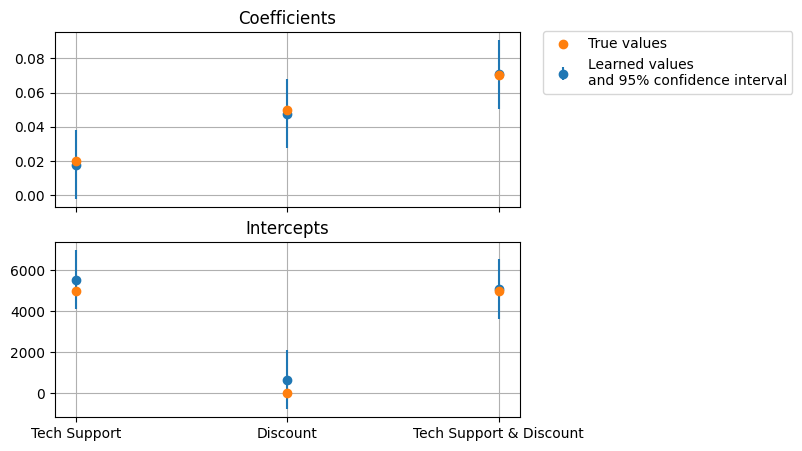

In [25]:
# Plot coefficients
plt.figure(figsize=(6, 5))
ax1 = plt.subplot(2, 1, 1)
plt.errorbar(
    coef_indices,
    coefs,
    coef_error,
    fmt="o",
    label="Learned values\nand 95% confidence interval",
)
plt.scatter(coef_indices, true_coefs, color="C1", label="True values", zorder=3)
plt.xticks(coef_indices, treatment_names)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title("Coefficients")
plt.legend(loc=(1.05, 0.65))
plt.grid()

# Plot intercepts
plt.subplot(2, 1, 2)
plt.errorbar(coef_indices, intercepts, intercept_error, fmt="o")
plt.scatter(coef_indices, true_intercepts, color="C1", zorder=3)
plt.xticks(coef_indices, treatment_names)
plt.title("Intercepts")
plt.grid()
plt.show()